These are the plots for comparing coordinate descent convergence and computational time with and without the SAFE rule.

Initialize the problem setup, using a lambda close to lambda_max to ensure enough variables are screened out.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(42)
n, p = 100, 200
X = np.random.randn(n, p)
niter = 50

theta_true = np.zeros(p)
non_zero_indices = np.random.choice(p, size=10, replace=False)
theta_true[non_zero_indices] = np.random.uniform(1, 5, size=10)

noise = 0.01 * np.random.randn(n)
y = X @ theta_true + noise

lmbda_max = np.linalg.norm(X.T @ y, ord=np.inf)
l = lmbda_max*0.7

Get the optimal theta using CVX for the lasso problem:

In [4]:
theta = cp.Variable(p)
lasso_objective = cp.Minimize(0.5 * cp.sum_squares(X @ theta - y) + l * cp.norm1(theta))
problem = cp.Problem(lasso_objective)
problem.solve()
theta_hat_cvxpy = theta.value

Now run pure coordinate descent for objective:

In [5]:
cd_theta = np.random.randn(p)
log_errors_cd = []
for k in range(niter):
    for j in range(p):
        rho = X[:, j].T @ (y - X @ cd_theta + X[:, j] * cd_theta[j])
        if rho < -l:
            cd_theta[j] = (rho + l) / (X[:, j].T @ X[:, j])
        elif rho > l:
            cd_theta[j] = (rho - l) / (X[:, j].T @ X[:, j])
        else:
            cd_theta[j] = 0
    error = np.linalg.norm(cd_theta - theta_hat_cvxpy)
    log_errors_cd.append(np.log(error))

Now we will re-run coordinate descent for the same objective, but this time screening out some variables that become 0 in $$\Beta_i$$

In [6]:
safe_theta = np.random.randn(p)
log_errors_safe = []
screened_out_count = 0
total_vars=0
for k in range(niter):
    for j in range(p):
        total_vars+=1
        inner_product = np.abs(X[:, j].T @ y)
        threshold = (l - (np.linalg.norm(X[:, j], ord=2) * np.linalg.norm(y, ord=2) * (lmbda_max - l) / lmbda_max))
        if inner_product < threshold:
            screened_out_count += 1
            safe_theta[j] = 0
            continue
        rho = X[:, j].T @ (y - X @ safe_theta + X[:, j] * safe_theta[j])
        if rho < -l:
            safe_theta[j] = (rho + l) / (X[:, j].T @ X[:, j])
        elif rho > l:
            safe_theta[j] = (rho - l) / (X[:, j].T @ X[:, j])
        else:
            safe_theta[j] = 0
    error = np.linalg.norm(safe_theta - theta_hat_cvxpy)
    log_errors_safe.append(np.log(error))
print(f" {screened_out_count} variables screened out out of {total_vars} total variables")

 5400 variables screened out out of 10000 total variables


Now we will plot the log error vs iteration for both methods, to compare convergence rates:

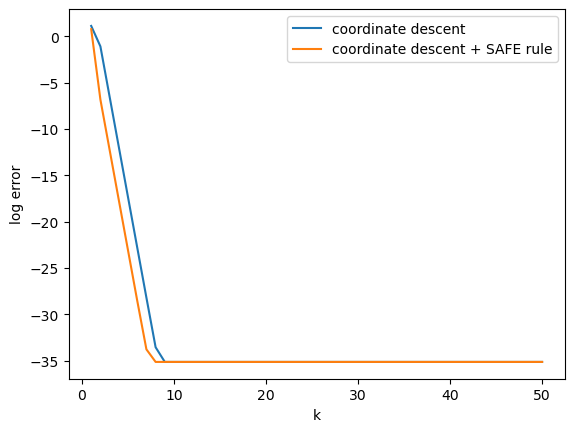

In [7]:
plt.figure()
plt.plot(range(1, niter + 1), log_errors_cd, label="coordinate descent")
plt.plot(range(1, niter + 1), log_errors_safe, label="coordinate descent + SAFE rule")
plt.xlabel("k")
plt.ylabel("log error")
plt.legend()
plt.show()

As you can see, the error in both methods approaches 0, but the SAFE rule enhanced method converges in fewer iterations due to screening out those variables that are 0 in the optimal solution.